# De-novo mutation enrichment analysis pipeline

This Jupyter notebook evaluates whether candidate de-novo mutations show enrichment across a variety of genomic annotations.

To run this notebook, you need:
- Variant files for transmitted blocks, located under `data/variants`. Please use variant files generated using step 2_call_variants from switch_errors pipeline
- Transmitted blocks definition, located under `data/blocks/results.json`. Please use results.json file generated by switch_errors pipeline
- Various genomic annotations for PAN027 assembly

In [39]:
import gzip
import os
import glob
import math
import random
from pathlib import Path
from multiprocessing import Pool
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from bisect import bisect_left
import json
import pandas as pd
from collections import defaultdict
import subprocess

In [40]:
DATA_JSON: str = "data/blocks/results.json"     # path to transmitted blocks definition from switch_errors pipeline
experiment_dir: Path = Path("data/experiment")  # path to experiment directory (where annotations are located, and results are stored)
experiment_dir.mkdir(exist_ok=True)


# -----------------------
# EXPERIMENT PARAMETERS  
# -----------------------
EXPERIMENT: str  = "Meiotic Recombination | SNVs"
ANNOTS_DIR: Path = experiment_dir / "annots_recomb"

# for loading annotations, we need to determine "type" or "kind" for each annotation
# this is done by specifying ANNOTS_FIELD = <int>, denoting which column of BED file is used for determining annotation type
# and by specifying ANNOTS_TYPE_LAMBDA = <callable[[str], str]>, which takes in the value from beforementioned BED column, and transforms it into "annotation type"
# we provide various annotation type lambdas used for analyses in the article

def annot_lambda_censat(val: str) -> str | list[str]:  # annotation lambda used for censat annotations
    if "cenSat" in val:
        return val.split('(')[1].split(')')[0].split(',')
    if '(' not in val:
        return val
    return val.split('(')[0]

annot_lambda_biser = lambda val: 'maternal' if 'maternal' in val else 'paternal'
annot_lambda_segdup = lambda val: "segdup"
annot_lambda_repeatmasker = lambda val: val

ANNOTS_TYPE_LAMBDA = annot_lambda_censat
ANNOTS_FIELD = 3

INDELS = False  # process indels from variant files
SNVs = True     # process SNVs from variant files

N_PERMS = 10_000    # number of permutations
SEED = 42           # seed for shuffling
WORKERS = 48        # number of workers for parallelization
OUT_PREFIX = experiment_dir
TOP_K_PLOTS = 12    # plot top K most enriched/depleted annotation types

ONLY_OVERLAP = False    # if True, don't calculate distance, use only 1/0 for overlaps annotation type or not

# ---------------------------------------
# Paths to files created by this notebook
# ---------------------------------------

EXCLUSIONS_BED: str = "data/plots/EXCLUSION.bed"
VARIANTS_BED: Path = experiment_dir / "variants_new.bed"
variants_shuffle_bed: Path = experiment_dir / "variants.shuffle.bed"
GENOME_FILE: Path = experiment_dir / "genome.txt"


# 1. Prepare data for analysis

We start by loading variants from transmitted blocks' variant calling and saving them into BED file for reshuffling.
 Next, we will continue with determining size of all chromosomes where variants will be reshuffled.
 Finally, we aggregate all regions covered by transmitted blocks and create their complement w.r.t. chromosome size. These so-called exclusions
 will make sure that variants are reshuffled only on positions where they could have been observed.

In [41]:
def run_cmd(cmd: list[str], output_path: str | None = None) -> None:
    """
    Run a shell command safely, with optional redirected output to file
    """

    print("[CMD]", " ".join(cmd))
    try:
        if output_path is not None:
            with open(output_path, "w") as out:
                subprocess.run(cmd, check=True, stdout=out, stderr=subprocess.PIPE)
        else:
            subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.PIPE)
    except Exception as exc:
        print(exc.stderr)

In [42]:
def parse_vcf_line(line: str) -> tuple[str, int, int, str, tuple[str, str]]:
    """
    Parse a VCF variant line with block-style contig names into BED coordinates
    Returns reference contig, start position, end position, info field, and both reference and alternative alleles
    """

    parts = line.strip().split("\t")
    ref_field = parts[0]  # e.g. PAN027.chr1.maternal:144216130-144939231
    ref_pos_rel = int(parts[1])
    ref_allele = parts[3]
    alt_allele = parts[4]
    info_field = parts[7]

    ref_contig, coords = ref_field.split(":")
    ref_block_start, ref_block_end = map(int, coords.split("-"))

    ref_abs_start = ref_block_start + ref_pos_rel - 1
    ref_abs_end = ref_abs_start + len(ref_allele) - 1

    info = f"{ref_contig}:{ref_abs_start}-{ref_abs_end}:{ref_allele}>{alt_allele}"
    return ref_contig, ref_abs_start, ref_abs_end, info, (ref_allele, alt_allele)

In [43]:
def build_variant_bed(data_json_path: str, output_bed: Path, exclude_bed: str) -> None:
    """
    Aggregate all variants, convert to BED, and subtract excluded regions
    """

    output_tmp: Path = Path(output_bed).with_suffix(".tmp.bed")
    with open(data_json_path) as f:
        dataset = json.load(f)["data"]

    maternal = paternal = 0
    with open(output_tmp, "w") as out:
        for record in dataset:
            vcf_path: Path = Path("data/variants") / Path(record["variants"]).name
            if not vcf_path.exists():
                print(f"Skipping missing {vcf_path}")
                continue

            opener = gzip.open if vcf_path.suffix == ".gz" else open
            with opener(vcf_path, "rt") as vcf:
                for line in vcf:
                    if line.startswith("#"):
                        continue
                    try:
                        contig, start, end, info, alleles = parse_vcf_line(line)
                        if not INDELS and any(len(a) > 1 for a in alleles):
                            continue  # only SNVs
                        if not SNVs and all(len(a) == 1 for a in alleles):
                            continue  # only SNVs
                        if "maternal" in contig:
                            maternal += 1
                        else:
                            paternal += 1
                        out.write(f"{contig}\t{start}\t{end}\t{info}\n")
                    except Exception as e:
                        print(f"Skipping malformed line in {vcf_path}: {e}")

    run_cmd([ # Subtract excluded regions
        "bedtools", "subtract",
        "-a", str(output_tmp),
        "-b", str(exclude_bed)
    ], str(output_bed))
    print(f"Variants BED written to {output_bed}")
    print(f"maternal {maternal}, paternal {paternal}")
    os.remove(output_tmp)

In [44]:
def build_genome_file(fasta_dir: str, genome_out: Path) -> None:
    """
    Build genome file (chrom sizes) for bedtools shuffle
    One line per fasta: <chrom>\t<size>
    """

    with open(genome_out, "w") as g:
        for fasta in Path(fasta_dir).rglob("*.fasta"):
            chrom = fasta.stem
            size = None
            run_cmd(["samtools", "faidx", str(fasta)], None)
            with open(str(Path(fasta).with_suffix('.fasta.fai'))) as fai:
                size = int(fai.readline().split()[1])
            g.write(f"{chrom}\t{size}\n")
    print(f"Genome file written to {genome_out}")

In [45]:
def build_exclusions_bed(data_json_path: str, genome_file: Path, exclusions_out: str) -> None:
    """
    Create complement of transmitted blocks (regions outside transmission)
    """

    tmp_blocks: Path = Path(exclusions_out).with_suffix(".tmp.bed")
    tmp_sorted_blocks: Path = Path(exclusions_out).with_suffix(".tmp.sorted.bed")

    with open(data_json_path) as f:
        dataset = json.load(f)["data"]

    with open(tmp_blocks, "w") as out:
        for rec in dataset:
            for role in ["grandparent", "parent", "daughter"]:
                asm: str = rec[f"{role}_assembly"]
                start: str = rec[f"{role}_from"]
                end: str = rec[f"{role}_to"]
                out.write(f"{asm}\t{start}\t{end}\n")
    
    run_cmd(["bedtools", "sort", "-faidx", str(genome_file), "-i", str(tmp_blocks)], str(tmp_sorted_blocks))

    run_cmd([
        "bedtools", "complement",
        "-i", str(tmp_sorted_blocks),
        "-g", str(genome_file)
    ], str(exclusions_out))
    print(f"Exclusions BED written to {exclusions_out}")
    os.remove(tmp_blocks)
    os.remove(tmp_sorted_blocks)


In [46]:
build_variant_bed(DATA_JSON, VARIANTS_BED, EXCLUSIONS_BED)

[CMD] bedtools subtract -a data/experiment/variants_new.tmp.bed -b data/plots/EXCLUSION.bed
✅ Variants BED written to data/experiment/variants_new.bed
maternal 633, paternal 513


In [17]:
build_genome_file("data/genomes", GENOME_FILE)

[CMD] samtools faidx data/genomes/PAN010/haplotype2/PAN010.chr3.haplotype2.fasta
[CMD] samtools faidx data/genomes/PAN010/haplotype2/PAN010.chr12.haplotype2.fasta
[CMD] samtools faidx data/genomes/PAN010/haplotype2/PAN010.chr5.haplotype2.fasta
[CMD] samtools faidx data/genomes/PAN010/haplotype2/PAN010.chr4.haplotype2.fasta
[CMD] samtools faidx data/genomes/PAN010/haplotype2/PAN010.chr11.haplotype2.fasta
[CMD] samtools faidx data/genomes/PAN010/haplotype2/PAN010.chr15.haplotype2.fasta
[CMD] samtools faidx data/genomes/PAN010/haplotype2/PAN010.chr14.haplotype2.fasta
[CMD] samtools faidx data/genomes/PAN010/haplotype2/PAN010.chr1.haplotype2.fasta
[CMD] samtools faidx data/genomes/PAN010/haplotype2/PAN010.chr9.haplotype2.fasta
[CMD] samtools faidx data/genomes/PAN010/haplotype2/PAN010.chr21.haplotype2.fasta
[CMD] samtools faidx data/genomes/PAN010/haplotype2/PAN010.chr22.haplotype2.fasta
[CMD] samtools faidx data/genomes/PAN010/haplotype2/PAN010.chrX.haplotype2.fasta
[CMD] samtools faidx d

In [47]:
build_exclusions_bed(DATA_JSON, GENOME_FILE, EXCLUSIONS_BED)

[CMD] bedtools sort -faidx data/experiment/genome.txt -i data/plots/EXCLUSION.tmp.bed
[CMD] bedtools complement -i data/plots/EXCLUSION.tmp.sorted.bed -g data/experiment/genome.txt
✅ Exclusions BED written to data/plots/EXCLUSION.bed


# A. Variant shuffling

We continue with functions to perform permutation re-shuffles of variants within transmitted blocks

In [48]:
def shuffle_variants(variants_bed: Path, genome_file: Path, exclusions_bed: Path, shuffled_bed: Path) -> None:
    """
    Shuffle variants inside allowed regions only
    Input: variants_bed, genome_file, exclusion_bed (from previous step)
    Output: shuffled_bed, a path where to save reshuffled variants
    """

    run_cmd([
        "bedtools", "shuffle",
        "-i", str(variants_bed),
        "-g", str(genome_file),
        "-excl", str(exclusions_bed),
        "-maxTries", "1000"
    ], str(shuffled_bed))
    print(f"Shuffled variants written to {shuffled_bed}")

In [49]:
def shuffle_variants_memory(variants_bed: Path, genome_file: Path, exclusions_bed: Path,
                                  seed=None, preserve_chrom=True, max_tries=1000) -> dict[str, list[int]]:
    """
    Run bedtools shuffle on variants_bed and return dict contig -> sorted list of midpoints (0-based).
    - preserve_chrom: if True adds -chrom so each variant stays on same contig
    - seed: integer seed for bedtools (optional)
    Practically the same as shuffle_variants, with reading of bedtools output directly
    """

    cmd: list[str] = ["bedtools", "shuffle", "-i", str(variants_bed), "-g", str(genome_file),
                      "-excl", str(exclusions_bed), "-maxTries", str(max_tries)]
    if preserve_chrom:
        cmd.append("-chrom")
    if seed is not None:
        cmd.extend(["-seed", str(int(seed))])

    try:
        proc = subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    except subprocess.CalledProcessError as e:
        msg = f"bedtools shuffle failed (rc={e.returncode}). stderr:\n{e.stderr}"
        raise RuntimeError(msg)

    sampled = defaultdict(list)
    for ln in proc.stdout.splitlines():
        if not ln.strip() or ln.startswith("#"):
            continue
        parts: list[str] = ln.split("\t")
        contig: str = parts[0]
        start: int = int(parts[1])
        end: int = int(parts[2])
        pos: int = (start + end) // 2
        sampled[contig].append(pos)

    for c in list(sampled.keys()):
        sampled[c] = sorted(sampled[c])

    return sampled

# B. Annotations processing

Next, we continue with loading annotations for enrichment experiment

In [50]:
def load_annotation_beds(annots_dir: Path, type_lambda: Callable[[str], str] = None) -> tuple[dict, list[str], int, bool]:
    """
    Load all annotation beds in folder
    Returns:
        - dictionary of annotation type -> contig -> annotation positions
        - list of all annotation types
        - number of annotation types
        - boolean indicating if annotations overlap

    Note: this script utilizes ANNOTS_FIELD and ANNOTS_TYPE_LAMBDA from experiment definition
    """

    annotations = defaultdict(list)
    annots_count = defaultdict(int)
    types = set()

    for bed in sorted(glob.glob(os.path.join(annots_dir, "*.bed"))):
        with open(bed) as fh:
            for line in fh:
                if not line.strip() or line.startswith("#"):
                    continue
                parts: list[str] = line.rstrip("\n").split("\t")
                if len(parts) < 3:
                    continue
                contig: str = parts[0]
                start: int = int(parts[1])
                end: int = int(parts[2])

                if len(parts) >= ANNOTS_FIELD:
                    annot_type: str = parts[ANNOTS_FIELD] if type_lambda is None else type_lambda(parts[ANNOTS_FIELD])
                else:
                    annot_type: str = "unknown" if type_lambda is None else type_lambda("unknown")
                if isinstance(annot_type, str):
                    annotations[contig].append((start, end, annot_type))
                    types.add(annot_type)
                    annots_count[annot_type] += 1
                else:
                    for a in annot_type:
                        annotations[contig].append((start, end, a))
                        types.add(a)
                        annots_count[a] += 1

    # sort and merge intervals per contig & per type
    annotations_by_type = defaultdict(lambda: defaultdict(list))
    overlap_detected = False
    for contig, intervals in annotations.items():
        by_type = defaultdict(list)
        for s, e, t in intervals:
            by_type[t].append((s, e))
        for t, arr in by_type.items():
            arr_sorted = sorted(arr)
            merged = []
            for s, e in arr_sorted:
                if not merged:
                    merged.append([s, e])
                else:
                    if s <= merged[-1][1]:
                        if s < merged[-1][1]:
                            overlap_detected = True
                        if e > merged[-1][1]:
                            merged[-1][1] = e
                    else:
                        merged.append([s, e])
            annotations_by_type[t][contig] = [(a, b) for a, b in merged]
    return annotations_by_type, types, annots_count, overlap_detected

In [51]:
annots, types, counts, overlap = load_annotation_beds(ANNOTS_DIR, ANNOTS_TYPE_LAMBDA)
print(f"Found {len(types)} annotation types... (overlap={overlap})")

Found 2 annotation types... (overlap=False)


In [52]:
print(list(types)[:20])

['recomb_mat', 'recomb_pat']


# C. Calculating distance of variants to their nearest annotation (of interest)

Having re-shuffled variants and annotations ready, we continue with functions that calculate, for each variant, distance to nearest annotation of interest (i.e., of specific type)

In [53]:
def load_variants_bed(variants_bed: Path) -> dict:
    """
    Load (re-shuffled) variants BED
    Returns dict contig -> sorted list of midpoint positions (0-based)
    """

    variants = defaultdict(list)
    with open(variants_bed) as fh:
        for ln in fh:
            if not ln.strip() or ln.startswith("#"):
                continue
            parts: list[str] = ln.rstrip("\n").split("\t")
            contig: str = parts[0]
            start: int = int(parts[1])
            end: int = int(parts[2])
            pos: int = (start + end) // 2
            variants[contig].append(pos)

    for c in list(variants.keys()):
        variants[c] = sorted(variants[c])
    return variants

In [54]:
def build_interval_index(intervals: list[tuple[int, int]]) -> tuple[list[int], list[int]]:
    """
    Given sorted non-overlapping list of (s,e) returns starts, ends lists
    """

    if not intervals:
        return [], []
    starts: list[int] = [s for s, e in intervals]
    ends: list[int] = [e for s, e in intervals]
    return starts, ends

In [55]:
def distance_point_to_intervals(pos: int, starts: list[int], ends: list[int]) -> int | None:
    """
    Return distance from point pos (0-based) to nearest interval in starts/ends (non-overlapping), 0 if overlaps any.
    """
    if not starts:
        return None

    i: int = bisect_left(starts, pos)
    if i < len(starts) and starts[i] <= pos < ends[i]: # check current interval
        return 0

    best: int | None = None
    if i > 0: # distance to previous interval end
        d: int = pos - ends[i - 1] if pos >= ends[i - 1] else 0
        best = d
    if i < len(starts):
        d2: int = starts[i] - pos if pos <= starts[i] else 0
        best: int = d2 if best is None else min(best, d2)
    return int(best if best is not None else 10 ** 9)

In [61]:
def mean_distance_to_type_for_variants(variants_by_contig: dict, ann_index_by_type: dict, annotation_type: str, only_overlap: bool = False) -> tuple:
    """
    Compute mean distance of provided variants (dict contig->positions) to annotations of a given type
    ann_index_by_type: dict annotation_type -> dict contig -> (starts,ends)
    Returns:
      mean_distance (float),
      n_variants_used (int),
      n_overlap (int),
      pct_overlap (float)
    """

    ann_contigs_index = ann_index_by_type.get(annotation_type, {})
    if not ann_contigs_index:
        return float("nan"), 0, 0, 0.0

    dlist: list[int] = []
    n_overlap: int = 0
    for contig, positions in variants_by_contig.items():
        starts_ends = ann_contigs_index.get(contig)
        if not starts_ends:
            continue
        starts, ends = starts_ends
        for p in positions:
            d: int = distance_point_to_intervals(p, starts, ends)
            if d is None:
                continue
            if only_overlap:
                dlist.append(0 if d == 0 else 1)
            else:
                dlist.append(d)
            
            if d == 0:
                n_overlap += 1

    n_variants_used: int = len(dlist)
    if n_variants_used == 0:
        return float("nan"), 0, 0, 0.0

    mean_d: float = float(np.mean(dlist))
    pct_overlap: float = 100.0 * n_overlap / n_variants_used
    return mean_d, n_variants_used, pct_overlap, n_overlap

# D. Enrichment experiment

Finally, we perform permutation enrichment experiment

In [62]:
# optimization for multiprocessing
!export MKL_NUM_THREADS=1
!export NUMEXPR_NUM_THREADS=1
!export OMP_NUM_THREADS=1

In [63]:
def worker_mean_distance(task: tuple) -> tuple:
    """
    Worker wrapper for multiprocessing: computes mean distance for a single annotation type
    `task` is tuple (annotation_type, variants_by_contig, ann_index_by_type, only_overlap)
    Returns annotation type, mean distance, number of variants used, percentage of variants overlapping annotations, and absolute number of the same
    """

    annotation_type, variants_by_contig, ann_index_by_type, only_overlap_flag = task
    mean_dist, n, overlap_pct, overlap_n = mean_distance_to_type_for_variants(variants_by_contig, ann_index_by_type, annotation_type,
                                                      only_overlap_flag)
    return annotation_type, mean_dist, n, overlap_pct, overlap_n

In [64]:
def plot_enrichment_bar(df, out_prefix, n_perms, seed, context_text="Please enter title", annots_counts = None, overlap=False) -> None:
    """
    Plot enrichment bar plot for permutation experiment

    Parameters
    ----------
    df              - dataframe containing experimental results
    out_prefix      - prefix of file to save plot to
    n_perms         - number of permutations used
    seed            - seed used
    context_text    - experiment description
    annots_counts   - dictionary of annotation counts
    overlap         - boolean indicating whether annotations overlap

    Returns
    -------
    None
    """

    # --- Sort by fold enrichment ---
    df = df.sort_values("fold_enrichment", ascending=False).reset_index(drop=True)

    sns.set(style="whitegrid", context="talk")
    fig, ax = plt.subplots(figsize=(10, max(6, len(df) * 0.25)))

    # --- Compute color scale for significance ---
    df["neglog10_p"] = -np.log10(df["pval_emp"].replace(0, 1e-300))
    vmax = 4 # df["neglog10_p"].replace(-np.inf, 0).max()
    vmin = 0

    cmap = sns.color_palette("YlOrBr", as_cmap=True)  # rich, perceptually uniform
    cmap = plt.cm.ScalarMappable(norm=plt.Normalize(vmin, vmax), cmap=cmap)
    colors = cmap.to_rgba(df["neglog10_p"])

    # --- Plot bars ---
    bars = ax.barh(
        df["annotation_type"],
        df["fold_enrichment"].fillna(0),
        color=colors,
        edgecolor="black",
        linewidth=1
    )

    # --- Axis labels and title ---
    ax.set_xlabel("Fold enrichment\n(expected mean distance / observed mean distance)", fontsize=12)
    ax.set_ylabel("Annotation type", fontsize=12)
    ax.set_title(
        f"Annotation enrichment by mean distance\n({n_perms} permutations, seed={seed})",
        fontsize=13, pad=15
    )
    ax.invert_yaxis()
    ax.tick_params(axis='y', labelsize=8)

    # --- Vertical reference line at 1.0 ---
    ax.axvline(1.0, color="gray", lw=1.5, ls="--", alpha=0.8)
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    ax.text(
        1.0 - (xlim[1] - xlim[0]) * 0.02, ylim[1] + 0.75,
        "Depletion", ha="right", va="bottom", color="gray", fontsize=10
    )
    ax.text(
        1.0 + (xlim[1] - xlim[0]) * 0.02, ylim[1] + 0.75,
        "Enrichment", ha="left", va="bottom", color="gray", fontsize=10
    )

    # --- Add colorbar for -log10(p) scale ---
    sm = plt.cm.ScalarMappable(cmap=sns.color_palette("YlOrBr", as_cmap=True), norm=plt.Normalize(vmin, vmax))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.02)
    cbar.set_label("-log₁₀(empirical p-value)", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # --- Annotate bars with numeric fold enrichment, n, and % overlap ---
    for bar, val, n, pct, ty, p, z, a in zip(
        bars,
        df["fold_enrichment"].fillna(0),
        df["observed_n"],
        df["pct_overlap"],
        df["annotation_type"],
        df["pval_emp"],
        df["zscore"],
        df["abs_overlap"],
    ):
        pct = pct / 100
        label = f"{val:.2f} enrichment, p={p:.5f}, z={z:.2f}, n_total={annots_counts[ty]}, {pct:.6f}% overlap (n={a})"
    
        bar_x = bar.get_x()
        bar_w = bar.get_width()
        bar_y = bar.get_y()
        bar_h = bar.get_height()

        ax.text(
            bar_x + 0.02,
            bar_y + bar_h / 2,
            label,
            va="center",
            ha="left",
            fontsize=6,
            color="black",
            bbox=dict(
                facecolor="white",
                edgecolor="none",
                alpha=0.7,
                boxstyle="round,pad=0.2"
            )
        )


    # --- Context text ---
    fig.text(0.5, -0.02, context_text, ha="center", va="top", fontsize=11, style="italic", color="gray")

    if overlap:
        fig.text(
            0.5, 1.05, "ANNOTATIONS OVERLAP!",
            ha="center", va="bottom",
            fontsize=18, color="red", weight="bold",
            transform=ax.transAxes
        )

    fig.tight_layout()
    fig.savefig(str(out_prefix / "enrichment_fold_enrichment_bar.png"), dpi=200, bbox_inches="tight")
    plt.show()
    plt.close(fig)


In [65]:
def run_permutation_enrichment(
        variants_bed: Path, annots_dir: Path, data_json: str,
        n_perms: int = 1000, seed: int = 42, workers: int = WORKERS,
        only_overlap: bool = False, out_prefix: str = "enrichment"
) -> tuple:
    """
    Performs permutation enrichment analysis given

    Parameters
    ----------
    variants_bed    - variants used for permutations
    annots_dir      - annotations directory (please set necessary fields in experiment definition at notebook's start)
    data_json       - results.json
    n_perms         - number of permutations
    seed            - seed for random number generator
    workers         - number of parallel workers to use
    only_overlap    - if True, calculate only overlap (i.e., distance is either zero or one)
    out_prefix      - prefix for output files

    Returns
    -------
    result dataframe and permutation means by annotation type
    """

    rng_main = random.Random(seed)
    
    # 1) load annotations and types
    print("[1] Loading annotations ...")
    ann_index_by_type, types, annots_counts, overlap = load_annotation_beds(annots_dir, ANNOTS_TYPE_LAMBDA)
    types = sorted(list(types))
    print(f"  found {len(types)} annotation types")

    # 2) load variants (observed)
    print("[2] Loading variants ...")
    variants = load_variants_bed(variants_bed)
    n_variants_total = sum(len(v) for v in variants.values())
    print(f"  total variants loaded: {n_variants_total}")


    # 3) observed means
    print("[3] Computing observed mean distances for each annotation type ...")
    ann_index_by_type_starts = {}
    for t, contigs in ann_index_by_type.items():
        ann_index_by_type_starts[t] = {}
        for contig, ivs in contigs.items():
            starts, ends = build_interval_index(ivs)
            ann_index_by_type_starts[t][contig] = (starts, ends)

    # compute observed means
    tasks_obs = [(t, variants, ann_index_by_type_starts, only_overlap) for t in types]
    with Pool(processes=workers) as pool:
        res_obs = list(tqdm(pool.imap(worker_mean_distance, tasks_obs), total=len(tasks_obs), desc="obs types"))
    observed = {t: (m, n, op, on) for (t, m, n, op, on) in res_obs}

    # 4) permutations
    print(f"[4] Running {n_perms} permutations; shuffling done in main process, distances computed in pool with {workers} workers.")
    perm_means_by_type = {t: [] for t in types}

    with Pool(processes=workers) as pool:
        for i in tqdm(range(n_perms), desc="permutations"):
            seed_perm = rng_main.randint(0, 2 ** 31 - 1)

            sampled_variants = shuffle_variants_memory(
                VARIANTS_BED, GENOME_FILE, EXCLUSIONS_BED,
                seed=seed_perm, preserve_chrom=True, max_tries=1000
            )
            tasks = [(t, sampled_variants, ann_index_by_type_starts, only_overlap) for t in types]
            for t, mean_val, n_used, overlap_pct, overlap_n in pool.map(worker_mean_distance, tasks):
                perm_means_by_type[t].append(mean_val)

    # convert to arrays and compute stats
    print("[5] Aggregating results and computing statistics ...")
    results = []
    for t in types:
        obs_mean, obs_n, obs_overlap_p, obs_overlap_n = observed[t]
        perm_arr = np.array([v for v in perm_means_by_type[t] if not math.isnan(v)])
        if perm_arr.size == 0:
            perm_mean = np.nan
            perm_std = np.nan
            pval = np.nan
            fold = np.nan
            pval_one_sided = np.nan
            zscore = np.nan
            n_perm = np.nan
        else:
            perm_mean = float(np.mean(perm_arr))
            perm_std = float(np.std(perm_arr, ddof=1)) if perm_arr.size > 1 else 0.0
            fold = perm_mean / obs_mean if (not math.isnan(obs_mean) and obs_mean > 0) else np.nan
            count_le = int(np.sum(perm_arr <= obs_mean))
            count_ge = int(np.sum(perm_arr >= obs_mean))
            n_perm = int(perm_arr.size)
            pval_lower = (1 + count_le) / (1 + n_perm)
            pval_upper = (1 + count_ge) / (1 + n_perm)
            obs_dev = abs(obs_mean - perm_mean)
            perm_dev = np.abs(perm_arr - perm_mean)
            count_extreme = int(np.sum(perm_dev >= obs_dev))
            pval_two_sided = (1 + count_extreme) / (1 + n_perm)
            zscore = (obs_mean - perm_mean) / perm_std if perm_std > 0 else np.nan
            pval_emp = pval_two_sided
            pval_one_sided = pval_lower if fold > 1 else pval_upper

        results.append({
            "annotation_type": t,
            "observed_mean": obs_mean,
            "observed_n": obs_n,
            "pct_overlap": (obs_overlap_n / annots_counts[t] * 100) if annots_counts[t] != 0 else 0.0,
            "abs_overlap": obs_overlap_n,
            "perm_mean": perm_mean,
            "perm_sd": perm_std,
            "n_perm": n_perm,
            "fold_enrichment": fold,
            "pval_emp": pval_two_sided,
            "pval_oneside_emp": pval_one_sided,
            "zscore": zscore,
            "n_perms_effective": len(perm_means_by_type[t])
        })
    df = pd.DataFrame(results)
    df = df.sort_values("fold_enrichment", ascending=False).reset_index(drop=True)
    out_csv = out_prefix / "enrichment_summary.tsv"
    df.to_csv(str(out_csv), sep="\t", index=False)
    print(f"[OK] Summary written to {out_csv}")

    # 6) barplot long figure sorted by fold enrichment and permutation histograms
    print("[6] Plotting results ...")

    plot_enrichment_bar(df, out_prefix, n_perms, seed, context_text=EXPERIMENT, annots_counts=annots_counts, overlap=overlap)

    df = df.sort_values("pval_emp", ascending=True).reset_index(drop=True)
    topk = df.head(TOP_K_PLOTS)["annotation_type"].tolist()
    ncols = 2
    nrows = int(math.ceil(len(topk) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3.2*nrows))
    axes = axes.flatten()
    
    for ax, t in zip(axes, topk):
        perm_arr = np.array([v for v in perm_means_by_type[t] if not math.isnan(v)])
        obs_mean = df.loc[df["annotation_type"] == t, "observed_mean"].values[0]
        perm_mean = np.mean(perm_arr)
        fold = df.loc[df["annotation_type"] == t, "fold_enrichment"].values[0]
        pval = df.loc[df["annotation_type"] == t, "pval_emp"].values[0]
    
        ax.hist(perm_arr, bins=40, color="lightgray", edgecolor="black", alpha=0.8)
        ax.axvline(obs_mean, color="red", lw=2, label=f"Observed = {obs_mean:.2f}")
        ax.axvline(perm_mean, color="blue", lw=1.5, ls="--", label=f"Random mean = {perm_mean:.2f}")
    
        ax.set_xlabel("Mean variant distance", fontsize=10)
        ax.set_ylabel("Permutation count", fontsize=10)
        ax.legend(fontsize=8, frameon=False)
        ax.set_title(
            f"{t}\nFold={fold:.2f}, p={pval:.2g}",
            fontsize=10, pad=5
        )
    
    for j in range(len(topk), len(axes)):
        axes[j].axis("off")
    
    fig.suptitle(f"Permutation test distributions (top {len(topk)})", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.savefig(str(out_prefix / "enrichment_topk_perm_histograms.png"), dpi=200)
    plt.show()
    plt.close(fig)

    # Also save dataframe and permutation arrays
    df.to_csv(str(out_prefix / "enrichment_detailed.tsv"), sep="\t", index=False)
    np.save(str(out_prefix / "enrichment_perm_means.npy"), perm_means_by_type)  # dict-like; save as object
    print(f"[OK] Figures written to {out_prefix}_fold_enrichment_bar.png and {out_prefix}_topk_perm_histograms.png")
    return df, perm_means_by_type

[1] Loading annotations ...
  found 2 annotation types
[2] Loading variants ...
  total variants loaded: 1146
[3] Computing observed mean distances for each annotation type ...


obs types:   0%|          | 0/2 [00:00<?, ?it/s]

[4] Running 10000 permutations; shuffling done in main process, distances computed in pool with 48 workers.


permutations:   0%|          | 0/10000 [00:00<?, ?it/s]

[5] Aggregating results and computing statistics ...
[OK] Summary written to data/experiment/enrichment_summary.tsv
[7] Plotting results ...


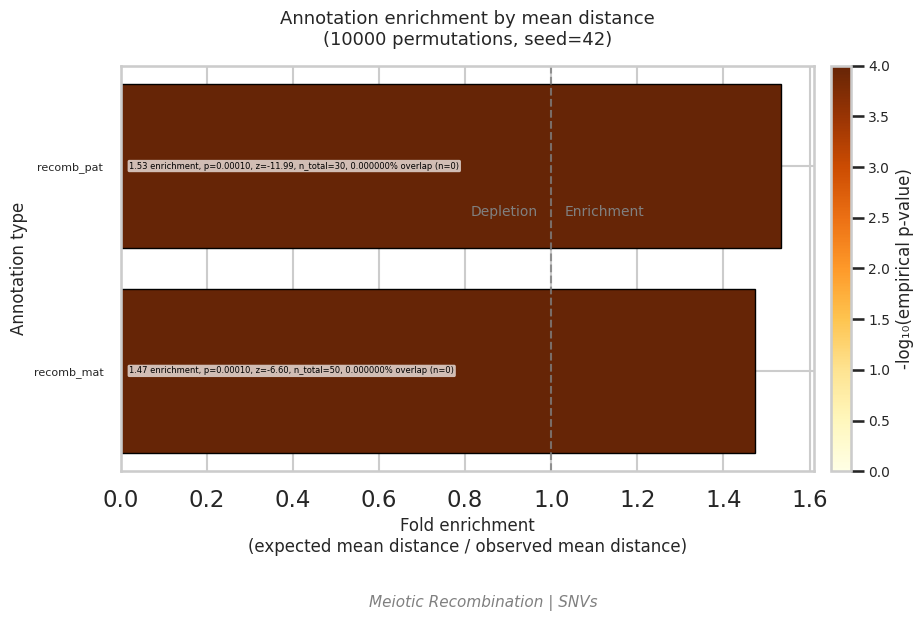

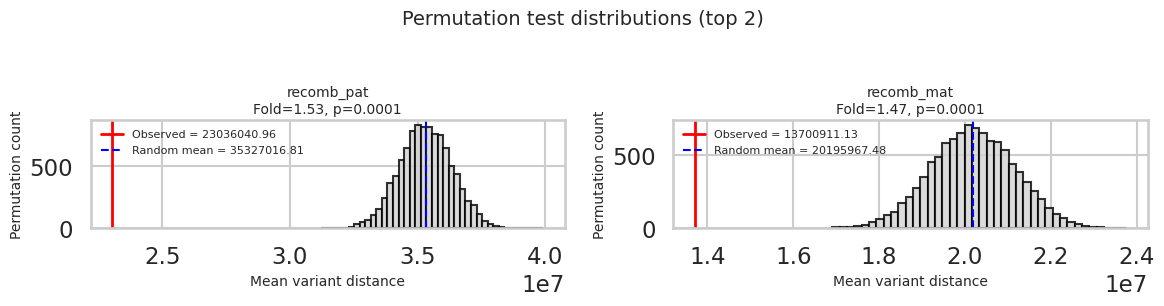

[OK] Figures written to data/experiment_fold_enrichment_bar.png and data/experiment_topk_perm_histograms.png
Done. Summary head:


,annotation_type,observed_mean,observed_n,pct_overlap,abs_overlap,perm_mean,perm_sd,n_perm,fold_enrichment,pval_emp,pval_oneside_emp,zscore,n_perms_effective
0,recomb_pat,2.303604e+07,482,0.0,0,3.532702e+07,1.024920e+06,10000,1.533554,0.0001,0.0001,-11.992135,10000
1,recomb_mat,1.370091e+07,436,0.0,0,2.019597e+07,9.839185e+05,10000,1.474060,0.0001,0.0001,-6.601214,10000


In [66]:
df_summary, perm_data = run_permutation_enrichment(
    VARIANTS_BED, ANNOTS_DIR, DATA_JSON,
    n_perms=N_PERMS, seed=SEED, workers=WORKERS,
    only_overlap=ONLY_OVERLAP, out_prefix=OUT_PREFIX
)
print("Done. Summary head:")
display(df_summary.head(40))